# Brusselator model

The Brusselator is a theoretical model for a type of autocatalytic reaction. 

The Brusselator model was proposed by Ilya Prigogine and his collaborators at the Université Libre de Bruxelles.
It is a portmanteau of Brussels and oscillator. 

It is characterized by the reactions 

$$
\begin{align*}
    A &\rightarrow X         \\
    B + X &\rightarrow Y + C \\
    2X + Y &\rightarrow 3X   \\
    X &\rightarrow D         \\
\end{align*}
$$

We can study the model assuming that $A$, $B$, $C$ and $D$ concentrations remain constants. 

In this way the only variables of the system are $X$ and $Y$.

The equations can be rewritten as

$$
\begin{align*}
    \frac{d[X]}{dt} &= +V_1  &\quad  \frac{d[Y]}{dt} &= 0     \\
    \frac{d[X]}{dt} &= -V_2  &\quad  \frac{d[Y]}{dt} &= +V_2  \\
    \frac{d[X]}{dt} &= +V_3  &\quad  \frac{d[Y]}{dt} &= -V_3  \\
    \frac{d[X]}{dt} &= -V_4  &\quad  \frac{d[Y]}{dt} &= 0     \\
\end{align*}
$$

Then, following the LAM and combining the previous equations we obtain

$$
\begin{align*}
    \frac{d[X]}{dt} &= [A] - [B]x + [X]^2[Y] - [X] \\
    \frac{d[Y]}{dt} &= [B]x - [X]^2[Y]             \\
\end{align*}
$$

where, for convenience, the rate constants have been set to 1. 

## Deterministic approach

Now it is time to move our analysis from math-theory to Python code.

We aim to visualize the solution of the system varying the two parameters $A$ and $B$.
First of all, we have to define the equations of our system and the integration algorithm (in this example we will use a Runge-Kutta 4th, ref. [here](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)).

In [2]:
Vx = lambda x, y, A, B : A + x*x*y - B*x - x
Vy = lambda x, y, A, B : B*x - x*x*y

def RK4 (x : float, y : float, dt : float, A : float, B : float) -> tuple:
    '''
    Runge Kutta 4th step algorithm
    
    Parameters
    ----------
        x : float
            Current step of x variable
            
        y : float
            Current step of y variable
            
        dt : float
            Time interval
            
        A : float
            Brusselator constant value
            
        B : float
            Brusselator constant value
            
    Returns
    -------
        xnew, ynew : tuple
            State of (x, y) at time t+1
    '''

    kx1 = dt * Vx(x, y, A, B)
    ky1 = dt * Vy(x, y, A, B)

    kx2 = dt * Vx(x + .5 * kx1, y + .5 * ky1, A, B)
    ky2 = dt * Vy(x + .5 * kx1, y + .5 * ky1, A, B)

    kx3 = dt * Vx(x + .5 * kx2, y + .5 * ky2, A, B)
    ky3 = dt * Vy(x + .5 * kx2, y + .5 * ky2, A, B)

    kx4 = dt * Vx(x + kx3, y + ky3, A, B)
    ky4 = dt * Vy(x + kx3, y + ky3, A, B)

    x_new = x + 1. / 6. * (kx1 + 2. * kx2 + 2. * kx3 + kx4)
    y_new = y + 1. / 6. * (ky1 + 2. * ky2 + 2. * ky3 + ky4)

    return (x_new, y_new)

Now we can declare our initial conditions and move to the system integration.

In [3]:
import numpy as np

# initial conditions
A, B = (.5, 2.)

dt = 1e-2
iterations = 10000

time = np.linspace(0, dt * iterations, iterations)
x = np.empty(shape=(iterations + 1), dtype=float)
y = np.empty(shape=(iterations + 1), dtype=float)

x[0] = 1.6
y[0] = 2.8

for i in range(0, iterations):
    x[i + 1], y[i + 1] = RK4(x[i], y[i], dt, A, B)

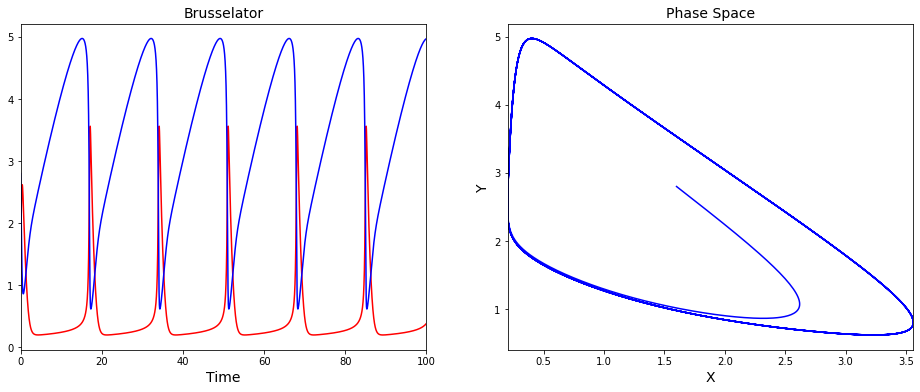

In [4]:
import pylab as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('', fontsize=14)
ax1.set_title('Brusselator', fontsize=14)

l1, = ax1.plot(time, x[:-1], color='r', label='x')
l2, = ax1.plot(time, y[:-1], color='b', label='y')

ax2.set_xlabel('X', fontsize=14)
ax2.set_ylabel('Y', fontsize=14)
ax2.set_title('Phase Space', fontsize=14)

l3, = ax2.plot(x, y, color='b')

ax1.margins(x=0)
ax2.margins(x=0)

#### Extra - C++ version

```c++
// g++ brusselator_rk4.cpp -std=c++14 -O3 -o brusselator_rk4

#include <memory>
#include <algorithm>
#include <cmath>
#include <type_traits>
#include <cassert>

template < class type >
using is_floating_point = typename std :: enable_if < std :: is_floating_point < type > :: value > :: type *;

template < class type, is_floating_point < type > = nullptr >
using array = std :: unique_ptr < type[] >;


/**
* @brief Brusselator kinetic
*
* @param t List of time points.
* @param x0 Initial condition of the x signal.
* @param y0 Initial condition of the y signal.
* @param A Constant of the reaction.
* @param B Constant of the reaction.
* @param x The resulting x array.
* @param y The resulting y array.
*
* @tparam type Data-type of arrays
* @tparam Length of time points.
*
*/
template < class type, int32_t N >
void Brusselator (const array < type > & t,
                  const type & x0, const type & y0, const type & A, const type & B,
                  array < type > & x, array < type > & y
                  )
{
  // determine the interval as diff
  const type dt = t[1] - t[0]; // Note: we are assuming it is constant!!

  // Set the initial condition
  x[0] = x0;
  y[0] = y0;

  // set the equation functions
  auto dx = [](const type & x, const type & y, const type & A, const type & B)
            {
              return A + x*x*y - B*x - x;
            };
  auto dy = [](const type & x, const type & y, const type & A, const type & B)
            {
              return B*x - x*x*y;
            };


  // Integrate the equations using the RK4 method
  for (int32_t i = 0; i < N - 1; ++i)
  {
    const type kx1  = dt * dx( x[i], y[i], A, B);
    const type ky1  = dt * dy( x[i], y[i], A, B);
    
    const type kx2  = dt * dx( x[i] + .5 * kx1, y[i] + .5 * ky1, A, B);
    const type ky2  = dt * dy( x[i] + .5 * kx1, y[i] + .5 * ky1, A, B);
    
    const type kx3  = dt * dx( x[i] + .5 * kx2, y[i] + .5 * ky2, A, B);
    const type ky3  = dt * dy( x[i] + .5 * kx2, y[i] + .5 * ky2, A, B);

    const type kx4  = dt * dx( x[i] + kx3, y[i] + ky3, A, B);
    const type ky4  = dt * dy( x[i] + kx3, y[i] + ky3, A, B);

    x[i + 1]  = x[i]  + type(1. / 6.) * (kx1 + type(2.) * kx2  + type(2.) * kx3 + kx4);
    y[i + 1]  = y[i]  + type(1. / 6.) * (ky1 + type(2.) * ky2  + type(2.) * ky3 + ky4);
  }
}


int32_t main (/*int32_t argc, char ** argv*/)
{
  const float x0  = 1.6f;
  const float y0  = 2.8f;

  const float A = .5f;
  const float B = 2.f;

  const int32_t iterations = 10000;
  const float dt = 1e-2f;

  array < float > time(new float[iterations]);
  std :: generate_n(time.get(), iterations, [n = 0, dt] () mutable { return dt * n++; });

  array < float > x(new float[iterations]);
  array < float > y(new float[iterations]);

  Brusselator < float, iterations >(time, x0, y0, A, B, x, y);;

  return 0;
}
```

## Stability Analysis

First of all we can study the stability points of this system of equations.

This can be achieved evaluating the derivative equation (posing their values to null)

$$
\begin{align*}
    A - Bx + x^2y - x &= 0 \\
    Bx - x^2y &= 0         \\
\end{align*}
$$

The solution of this system (very easy) lead to a single **critial point**

$$
\left(A, \frac{B}{A}\right)
$$

and inserting this point into the equations we obtained the Jacobian Matrix of the system

$$
J = \begin{bmatrix} B - 1 & A^2 \\ -B & -A^2 \end{bmatrix}
$$

from which we can evaluate the characteristic equation (aka determinant)

$$
L^2 + (1 - B + A^2) L + A^2 = 0
$$

This analysis lead to a couple of eigenvectors of the $J$ matrix which depends by the following equations

$$
1 - B + A^2 \quad\quad\quad \Delta = (1 - B + A^2)^2 - 4 A^2
$$

Now we can see how this system changes using different (and critical) parameters of $A$ and $B$.

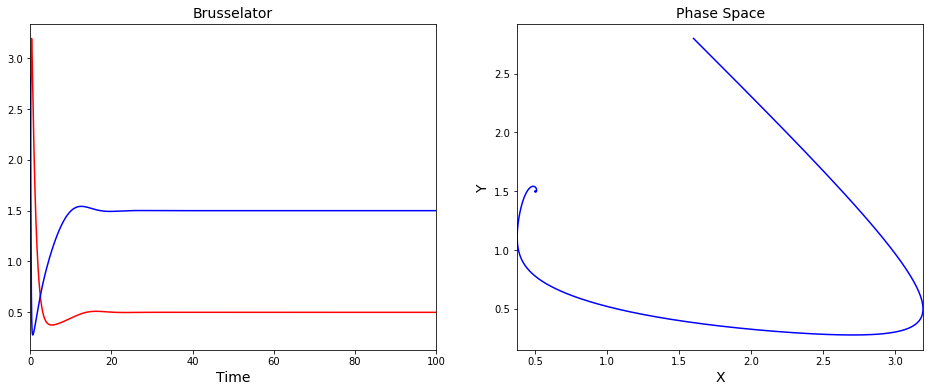

In [5]:
# 1st critical point
A = .5
B = 1 - A**2

dt = 1e-2
iterations = 10000

time = np.linspace(0, dt * iterations, iterations)
x = np.empty(shape=(iterations + 1), dtype=float)
y = np.empty(shape=(iterations + 1), dtype=float)

x[0] = 1.6
y[0] = 2.8

for i in range(0, iterations):
    x[i + 1], y[i + 1] = RK4(x[i], y[i], dt, A, B)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('', fontsize=14)
ax1.set_title('Brusselator', fontsize=14)

l1, = ax1.plot(time, x[:-1], color='r', label='x')
l2, = ax1.plot(time, y[:-1], color='b', label='y')

ax2.set_xlabel('X', fontsize=14)
ax2.set_ylabel('Y', fontsize=14)
ax2.set_title('Phase Space', fontsize=14)

l3, = ax2.plot(x, y, color='b')

ax1.margins(x=0)
ax2.margins(x=0)

## Chemical Master Equation approach

Brusselator is not a naive system for this study since it involves 2 equations *coupled* each other.
In this case we have to estimate all the possible states of our system and all the probability of transitions into a reticular structure (compared to the simpler linear one).

With a stochastic approach, considering a number of molecula about the Avogadro number we can write a CME of the Model. 
Assuming as starting point the state $n$ we have 4 possible state around that as shown in the scheme:

                            o (x-1 , y+1)

                            o (x-1, y)            o (x, y)          o (x+1 , y)

                                                                    o (x+1, y-1)
                                                                    
Each step will be correlated with a particular coefficient of ricombination (step back) and generation (step forward).
A key parameter of the Gillespie algorithm is the system dimension ($\omega$) which represents the connection between the deterministic and stochastic model.
In the CME model the $\omega$ parameter contributes in the reaction step with 2 or more molecular species.
In this case only the reaction 2 and 3 verify this conditions: in the first case we have to divide the constant reaction (= 1 in our case) for the $\omega$ value (1 specie) while in the second case there are 2 species so we divide the value for $\omega^2$.

In conclusion the CME system will be:

$$
\begin{align*}
    c_1 &= k_1 = 1 \\
    c_2 &= \frac{k_2}{\omega} = \frac{1}{\omega} \\
    c_3 &= \frac{2k_3}{\omega^2} = \frac{2}{\omega^2} \\
    c_4 &= k_4 = 1 \\
\end{align*}
$$

and combining all together the CME becomes

$$
\begin{align*}
    \frac{dP(x, y, t)}{dt} = &-(c_1A + c_2B + c_3x^2y + c_4x)P(x, y, t) \\
                             &+ c_1A P(x - 1, y, t) \\
                             &+ c_2B (x + 1) P(x + 1, y - 1, t) \\
                             &+ c_3 (x - 1)(x - 2)(y + 1) P(x - 1, y + 1, t) \\
                             &+ c_4 (x + 1) P(x + 1, y, t) \\
\end{align*}
$$

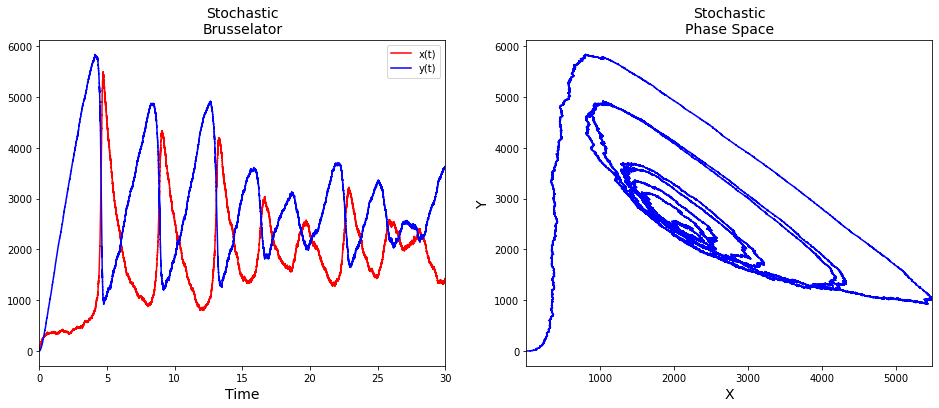

In [6]:
𝜔 = 1000.
A = 2
B = 5.2
x0, y0 = (1.6, 2.8)

ti = 0.0
tf = 30

# fix the random number generator
np.random.seed(42)

x, y, t = [x0], [y0], [ti]

while ti < tf:
    
    xi, yi = x[-1], y[-1]
    
    # define the set of reactions
    c = [A * 𝜔, 
         A * 𝜔 + B * xi,
         A * 𝜔 + B * xi + xi,
         A * 𝜔 + B * xi + xi + xi * (xi - 1) * yi / 𝜔**2,
        ]
    
    rng1, rng2 = np.random.uniform(low=0., high=1., size=(2, ))
    
    𝜏 = -np.log(rng1)/c[-1]
    uct = rng2 * c[-1]
    
    ti += 𝜏
    
    if uct < c[0]: 
        xi += 1
    elif uct < c[1]:
        xi -= 1
        yi += 1
    elif uct < c[2]:
        xi -= 1
    elif uct < c[3]:
        xi += 1
        yi -= 1
        
    x.append(xi)
    y.append(yi)
    t.append(ti)
    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('', fontsize=14)
ax1.set_title('Stochastic\nBrusselator', fontsize=14)

l1, = ax1.plot(t, x, color='r', label='x(t)')
l2, = ax1.plot(t, y, color='b', label='y(t)')
ax1.legend()

ax2.set_xlabel('X', fontsize=14)
ax2.set_ylabel('Y', fontsize=14)
ax2.set_title('Stochastic\nPhase Space', fontsize=14)

l3, = ax2.plot(x, y, color='b')

ax1.margins(x=0)
ax2.margins(x=0)

The obtained trajectories are noisier than the deterministic ones, and also the phase space orbits are unstable.
More realizations of the same stochastic dynamics could improve the quality of the results, as much as a tuning of the $\omega$ parameter.

#### Extra - C++ version

The C++ version of this algorithm could help us to implement multiple stochastic realizations of the dynamic evolutions with better computational performances.

The implementation will trace the Python code, with just some tricks for the visualization via OpenCV.

```c++
//g++ ChemicalMasterEquation.cpp -O3 -std=c++11 `pkg-config opencv --cflags --libs` -o CME
#include <iostream>
#include <random>
#include <opencv2/opencv.hpp>
#include <opencv2/plot.hpp>


void BrusselatorCME (std :: vector < double > & x, std :: vector < double > & y,
                     std :: vector < double > & t,
                     const double & A, const double & B,
                     const double & omega, double max_time = 30.,
                     std :: size_t seed = 123)
{
  double ti = t[0];
  double xi = x[0];
  double yi = y[0];

  std :: mt19937 mt(seed);
  std :: uniform_real_distribution < double > uniform(0., 1.);

  while (ti <= max_time)
  {
    std :: cout << "\rTime " << ti << std :: flush;

    std :: array < double, 4 > c{ {A * omega,
                                   A * omega + B * xi,
                                   A * omega + B * xi + xi,
                                   A * omega + B * xi + xi + xi * (xi - 1.) * yi / (omega * omega)
                                   }
                                 };

    const double rng1 = uniform(mt);
    const double rng2 = uniform(mt);
    const double tau = -std :: log(rng1) / c[3];
    const double uct = rng2 * c.back();

    ti += tau;

    if     (uct < c[0]) ++xi;
    else if(uct < c[1]) {--xi; ++yi;}
    else if(uct < c[2]) --xi;
    else if(uct < c[3]) {++xi; --yi;}

    x.push_back(xi);
    y.push_back(yi);
    t.push_back(ti);
  }

}

int main (int argc, char ** argv)
{
  const double A = 2.;
  const double B = 5.2;

  const double omega = 1000.;

  const double x0 = 1.6;
  const double y0 = 2.8;

  std :: vector < double > x = {x0};
  std :: vector < double > y = {y0};
  std :: vector < double > t = {0.};

  BrusselatorCME (x, y, t, A, B, omega, 30., 42);

  cv :: Mat plot_x;
  cv :: Mat plot_y;

  cv :: Ptr < cv :: plot :: Plot2d > plot = cv :: plot :: Plot2d :: create(cv :: Mat(x));
  plot->setPlotBackgroundColor( cv :: Scalar( 0, 0, 0 ) );
  plot->setPlotLineColor( cv :: Scalar( 255, 0, 0 ) );
  plot->setPlotAxisColor( cv :: Scalar( 255, 255, 255 ) );
  plot->setPlotGridColor( cv :: Scalar( 127, 127, 127 ) );
  plot->setPlotLineWidth(2);
  plot->setInvertOrientation(true);
  plot->setShowText(false);

  plot->render( plot_x );

  cv :: Mat plot_res;

  plot = cv :: plot :: Plot2d :: create(cv :: Mat(y));
  plot->setPlotAxisColor( cv :: Scalar( 255, 255, 255 ) );
  plot->setPlotLineColor( cv :: Scalar( 0, 0, 255 ) );
  plot->setPlotGridColor( cv :: Scalar( 127, 127, 127 ) );
  plot->setPlotLineWidth(2);
  plot->setInvertOrientation(true);
  plot->setShowText(false);
  plot->render( plot_y );

  plot_res = plot_x | plot_y;

  cv :: namedWindow("Brusselator CME", cv :: WINDOW_FULLSCREEN);
  cv :: moveWindow("Brusselator CME", 0, 10);
  cv :: imshow("Brusselator CME", plot_res);

  cv :: waitKey(0);

  return 0;
}

```

## Turing Pattern

One of the fundamental questions in developmental biology is how the vast range of pattern and structure we observe in nature emerges from an almost uniformly homogeneous fertilized egg. 
In particular, the mechanisms by which biological systems maintain robustness, despite being subject to numerous sources of noise, are shrouded in mystery.

The *Turing pattern* is a concept introduced by English mathematician Alan Turing in a 1952 paper titled [*The Chemical Basis of Morphogenesis*](https://www.dna.caltech.edu/courses/cs191/paperscs191/turing.pdf) which describes how patterns in nature, such as stripes and spots, can arise naturally and autonomously from a homogeneous, uniform state.
Turing examined the behaviour of a system in which two diffusible substances interact with each other, and found that such a system is able to generate a spatially periodic pattern even from a random or almost uniform initial condition.
Turing hypothesized that the resulting wavelike patterns are the chemical basis of **morphogenesis**.

Turing hypothesized that the patterns we observe during embryonic development arise in response to a spatial pre-pattern in biochemicals, which he termed morphogens. 
Cells would then respond to this pre-pattern by differentiating in a threshold-dependent way. 
Thus, Turing hypothesized that the patterns we see in nature, such as pigmentation in animals, branching in trees and skeletal structures, are reflections of inhomogeneities in underlying biochemical signalling.

To generate these pre-patterns, Turing considered the morphogens to be interacting in such a way that, in the well-mixed system, there would be a spatially uniform steady state which was stable to perturbations. 
He then proposed that, in the non-mixed system, this steady state would be driven unstable by diffusion. 
This is counterintuitive as diffusion is usually a stabilizing and a homogenizing process. 
In effect, what Turing showed was that from the interaction of two stabilizing processes, an instability could emerge. 
This is now called diffusion-driven instability (DDI) and the pattern is said to emerge or self-organize. The system Turing studied took the form

$$
\frac{\partial u}{\partial t} = D\nabla^2u + f(u)
$$

where $u$ is a vector of chemical concentrations, $D$ a matrix of constant diffusion coefficients (usually diagonal) and $f(u)$ the reaction kinetics (typically nonlinear). 
Appropriate boundary and initial conditions, which are often periodic and perturbations of the homogeneous steady state, respectively, are applied to close the system.

Turing patterns have also been produced experimentally in chemical systems, such as the *Belousov–Zhabotinsky* (BZ) reaction (ref. [here](https://en.wikipedia.org/wiki/Belousov%E2%80%93Zhabotinsky_reaction)), which has been found to be the most simple and prototypical example of pattern forming chemical reaction.
The Brusselator serves as a simple two-species model for the Belousov–Zhabotinsky reaction, a hypothetical oscillating chemical reaction system proposed by Prigogine in 1968 which is considered one of the simplest reaction–diffusion models exhibiting Turing and Hopf instabilities. 
The spatiotemporal evolution of the main variables is given by the following partial differential equations:

$$
\begin{align*}
    \frac{\partial u}{\partial t} = D_u\nabla^2 u + f(u, v) \\
    \frac{\partial v}{\partial t} = D_v\nabla^2 v + g(u, v) \\
\end{align*}
$$

where $D_u$ and $D_v$ are diffusion coefficients, $u$ and $v$ are concentrations of morphogens, $f$ and $g$ are nonlinear functions that represent the reaction kinetics, which for the Brusselator model are

$$
\begin{cases}
    f(u, v) &= A - (B + 1) u + u^2 v \\
    g(u, v) &= Bu - u^2v             \\
\end{cases}
$$

>⚠️**Note:** Note that the Turing kinetic model includes a basic assumption: the cells always live in a continuous patch environment. 
> However, this may not be the case in reality, and the motion of individuals of given cells is random and isotropic, i.e. without any preferred direction, the cells are also absolute individuals. 
> The cells or units are also absolute individuals in microscopic sense, and each isolated cell exchanges materials by diffusion with its neighbors.
> Thus, it is reasonable to consider a 1D or 2D spatially discrete reaction–diffusion system in order to explain the chemical system. 

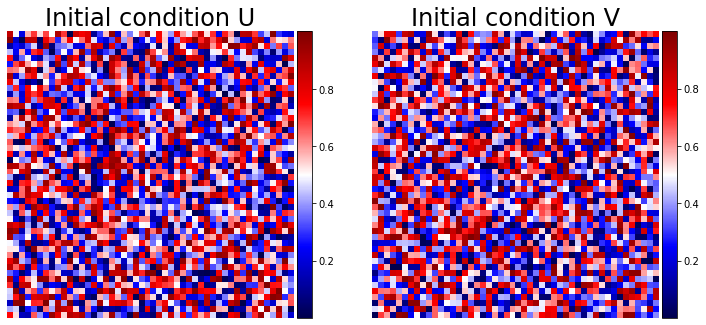

In [7]:
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

A, B = (4.5, 12.)
Du, Dv = (2., 12.)
sx, sy = (48, 48)

U = np.random.uniform(low=0., high=1., size=(sx, sy))
V = np.random.uniform(low=0., high=1., size=(sx, sy))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
im_U = ax1.imshow(U, cmap='seismic')
ax1.set_title('Initial condition U', fontsize=24)
ax1.axis('off')
im_V = ax2.imshow(V, cmap='seismic')
ax2.set_title('Initial condition V', fontsize=24)
ax2.axis('off')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_U, cax=cax, orientation='vertical', shrink=0.6)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_V, cax=cax, orientation='vertical', shrink=0.6)

In [15]:
from scipy.ndimage import laplace
import matplotlib.animation
from matplotlib import rc
import matplotlib
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 20971520*2

rc('animation', html='jshtml')

dt = 0.005
U = np.random.uniform(low=0., high=1., size=(sx, sy))
V = np.random.uniform(low=0., high=1., size=(sx, sy))

lap_u = np.empty_like(U)
lap_v = np.empty_like(V)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
im_U = ax.imshow(U, cmap='seismic', interpolation='None', animated=True)
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_U, cax=cax, orientation='vertical', shrink=0.6)
plt.close(fig)

def brusselator_diffusion (frame_index):
        
    laplace(input=U, output=lap_u, mode='wrap')
    laplace(input=V, output=lap_v, mode='wrap')
    
    uuv = U * U * V
    
    ut = dt * (Du * lap_u + (A - (B + 1.) * U + uuv)) + U
    vt = dt * (Dv * lap_v + (B * U - uuv)) + V
    
    U[:] = ut
    V[:] = vt
    
    im_U.set_data(ut)
    
    im_U.set_clim(ut.min(), ut.max())
    
    ax.set_title('Iter: {:d}'.format(frame_index))    
    
    return im_U,

ani = matplotlib.animation.FuncAnimation(fig, brusselator_diffusion, interval=1, frames=2000, blit=False)
ani.save('animationBrusselatorTuring.gif', writer='pillow', fps=1)

HTML(ani.to_html5_video())

#### Extra - C++ version

This kind of simulations can be very expensive in terms of computational time and an efficient version of the algorithm is often mandatory for an appropriated analysis of the model.
We would stress that in the above simulation we have used a $48\times48$ space-grid, while for larger simulation the computational time could increase exponentially.

A C++ version of the same code is proposed in the next section.
For the visualization and an efficient implementation of the laplacian computation (one of the most expensive step of the code above) we use the [OpenCV](https://github.com/opencv/opencv/) library.

```c++
//g++ brusselator.cpp -O3 -std=c++11 `pkg-config opencv --cflags --libs` -o brusselator -lpthread
#include <iostream>
#include <thread>
#include <opencv2/opencv.hpp>

/**
* @brief OpenCV viewer
*
* @details This function is used for the visualization of
* an OpenCV image and it could be used for an asynchronous
* visualization of the result.
*
* @note The input image is normalized between its Min-Max
* and converted to uint8_t before the visualization.
* A Jet colormap (do not tell to prof. Giampieri that I have
* used a Jet colormap, please!) is used for the color remapping.
*
* @param name Window name
* @param img OpenCV Mat to plot
* @param ms Wait time in ms
*
*/
void view (const std :: string & name, cv :: Mat & img, int32_t ms=1)
{
  cv :: Mat temp = img.clone();
  cv :: normalize(img, temp, 0, 255, cv :: NORM_MINMAX);
  temp.convertTo(temp, CV_8UC1 );

  cv :: applyColorMap(temp, temp, cv::COLORMAP_JET);
  cv :: imshow(name, temp);
  int c = cv :: waitKey(ms);
  c = (c != -1) ? c % 256 : c;

  if (c == 27)
  {
    cv :: destroyAllWindows();

    if (ms == 0)
      return;

    //std :: cout << std :: endl;
    std :: exit(0);
  }
}

/**
* @brief Brusselator diffusion model
*
* @note The visualization of the 1st morphogen
* is performed asynchronously during the update
* computation using std :: thread.
*
* @param U OpenCV Mat of the 1st morphogen
* @param V OpenCV Mat of the 2nd morphogen
* @param dt Interval of time
* @param A Kinetic reaction constant
* @param B Kinetic reaction constant
* @param Du Diffusion coef of the 1st morphogen
* @param Dv Diffusion coef of the 2nd morphogen
* @param iteration Number of iterations to perform
*
*/
void diffusion (cv :: Mat & U, cv :: Mat & V,
                const double & dt,
                const double & A, const double & B,
                const double & Du, const double & Dv,
                const int64_t & iteration)
{

  const std :: string name = "Turing Pattern";
  cv :: namedWindow(name, cv :: WINDOW_FULLSCREEN );


  for (int64_t t = 0; t < iteration; ++t)
  {
    std :: thread display = std :: thread(view, name, std :: ref(U), 1);

    cv :: Mat lap_u;
    cv :: Mat lap_v;

    // a wrap boundary condition should be more appropriated
    // but unfortunately OpenCV Laplacian doesn't support it :(
    cv :: Laplacian(U, lap_u, CV_64FC1, 1, 1, 0, cv :: BORDER_REFLECT_101);
    cv :: Laplacian(V, lap_v, CV_64FC1, 1, 1, 0, cv :: BORDER_REFLECT_101);

    cv :: Mat uuv = U.mul(U.mul(V));

    cv :: Mat Ut = dt * (Du * lap_u + (A - (B + 1.) * U + uuv)) + U;
    cv :: Mat Vt = dt * (Dv * lap_v + (B * U - uuv)) + V;

    U = Ut.clone();
    V = Vt.clone();

    //std :: cout << "\rTime: " << dt * t << std :: flush;
    cv :: setWindowTitle(name, name + " (Time: " + std :: to_string(dt * t) + ")");
    display.join();
  }
  //std :: cout << "\rTime: " << dt * iteration << std :: endl;
}


/**
* @brief Command line helper
*
* @details Utility function for the command line user.
*
* @param argv Array of command line arguments.
*
*/
void usage (char ** argv)
{
  std :: cerr << "Usage: " << argv[0] << " [A <double>] [B <double>] [Dx <double>] [Dy <double>] [dt <double>]"
              << std :: endl
              << "Default parameters:" << std :: endl
              << "\tA = 4.5" << std :: endl
              << "\tB = 4.75" << std :: endl
              << "\tDx = 2.0" << std :: endl
              << "\tDy = 16.0" << std :: endl
              << "\tdt = 0.005" << std :: endl
              << std :: endl;
  std :: exit(1);
}



/**
* @brief Command line parser
*
* @details Parse the command line arguments
* and (eventually) set default values of the
* required variables.
* If something goes wrong the helper function
* is called.
*
* @param argc Number of arguments in command line.
* @param argv Array of command line arguments.
* @param A Kinetic reaction constant
* @param B Kinetic reaction constant
* @param Dx Diffusion coef of the 1st morphogen
* @param Dy Diffusion coef of the 2nd morphogen
* @param dt Interval of time
*
*/
void parse_args (int32_t argc, char ** argv,
                 double & A, double & B, double & Dx, double & Dy,
                 double & dt)
{
  switch (argc)
  {
    default: usage(argv);

    case 1:
    break;

    case 2:
    {
      A = std :: stod(argv[1]);
    } break;
    case 3:
    {
      B = std :: stod(argv[2]);
      parse_args(2, argv, A, B, Dx, Dy, dt);
    } break;
    case 4:
    {
      Dx = std :: stod(argv[3]);
      parse_args(3, argv, A, B, Dx, Dy, dt);
    } break;
    case 5:
    {
      Dy = std :: stod(argv[4]);
      parse_args(4, argv, A, B, Dx, Dy, dt);
    } break;
    case 6:
    {
      dt = std :: stod(argv[5]);
      parse_args(5, argv, A, B, Dx, Dy, dt);
    } break;
  }
}


int main (int argc, char ** argv)
{
  const int64_t dim = 512;

  double A = 4.5;
  double B = 4.5;
  double Du = 2.;
  double Dv = 16.;
  double dt = .005;

  parse_args(argc, argv, A, B, Du, Dv, dt);

  cv :: Mat U(dim, dim, CV_64FC1);
  cv :: Mat V(dim, dim, CV_64FC1);

  cv :: randu(U, cv :: Scalar(0.), cv :: Scalar(1.));
  cv :: randu(V, cv :: Scalar(0.), cv :: Scalar(1.));

  U = A + .3 * U;
  V = B/A + .3 * V;

  view("Initial condition", U, 0);

  diffusion(U, V, dt, A, B, Du, Dv, 6000);

  return 0;
}

```